# Model 1: "Trending" On YouTube: 
## An Unsupervised Learning Approach to the Categorical Understanding of Youtube Videos

## 1. Introduction and Data Aquisition:
When browsing YouTube, we realized that videos that are trending do not necessarily have similar statistics: some videos have a lot of comment per view count while some have little; some have a lot of likes while others are more controversial. The target of this model is to find different "clusters" of videos that share similar viewer statistics(views, likes, dislikes, comments, etc.) and examines the hidden reasons(different content, different channel, etc.) behind this phenomenon.

Our dataset, which is included in the folder, is the Kaggle dataset "Trending YouTube Video Statistics." (Link: https://www.kaggle.com/datasnaek/youtube-new#FRvideos.csv) The dataset we are examining as a sample will be the "USvideos.csv" dataset, but, as we will show briefly towards the end, this model is equally applicable for the analysis of datasets from other nations.

In [19]:
#Import all necessary directries for the model and the dataset itself, please run the codes sequencially so that no error pops out!
import pandas
import numpy
from numpy.random import uniform
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from random import sample
from math import isnan
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

trending_vid_data = pandas.read_csv('USvideos.csv')

trending_vid_data.head()
#trending_vid_data.describe()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


## 2. Data Cleaning and Preparation
Here, we can see there are both qualitative and quantitative data present in this dataset. We want to classify videos based on their view statistics, so only the following are kept as features, namely: views, likes, dislikes, and comment_count. 

To address the natural interdependency between the amount of likes/dislikes/comments and total view counts (i.e videos that have similar view counts tend to have similar like/dislike numbers), we decide to use the idea of "like rate" instead of the original data. This rate is computed by dividing the like/dislike by the total view. This process ensures view count does not have too much influence, on the final classification and it also performed normalization the three features by scaling data in the range between 0 and 1.  Now, the number of views (which is typically more then 10k) is too large and may cause too much influence on the final prediction. (Since K-means classification calculates the distance between a point and others, if one of the features is much larger then the other two, the distance difference will be mainly dependent on that feature.) To address this, the number of views is also normalized to the same range between o and 1 through min-max normalization. 

In [20]:
#Eliminate unnecessary columns
trending_vid_data_c = trending_vid_data.drop(axis=1 ,columns=['publish_time','video_id','trending_date','title','channel_title','category_id','tags','thumbnail_link','comments_disabled','ratings_disabled','video_error_or_removed','description'])
size =len(trending_vid_data_c.index)
trending_vid_data_c=trending_vid_data_c.astype('float64')
#Process into rates
for i in range(size):
    ratio1=trending_vid_data_c['likes'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['likes'][i]=ratio1
    
    ratio2=trending_vid_data_c['dislikes'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['dislikes'][i]=ratio2
    
    ratio3=trending_vid_data_c['comment_count'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['comment_count'][i]=ratio3
    
#Normalize view number
trending_vid_data_c['views']=(trending_vid_data_c['views']-trending_vid_data_c['views'].min())/(trending_vid_data_c['views'].max()-trending_vid_data_c['views'].min())
trending_vid_data_c.head()

,views,likes,dislikes,comment_count
0,0.003321,0.076869,0.003963,0.021318
1,0.010738,0.040179,0.002541,0.005252
2,0.014168,0.045758,0.001673,0.002563
3,0.001521,0.029641,0.001941,0.006253
4,0.009303,0.063097,0.000949,0.008359


### Additional Insight before modelling: Initial Data Visualization
Before developing the model, it may be helpful for us first to gain some insight into what the data looks like. Since there are four features, it is impossible to plot all four columns into one 3d plot, but we can plot several 3d plots with 3 out of 4 elements and see what it looks like.

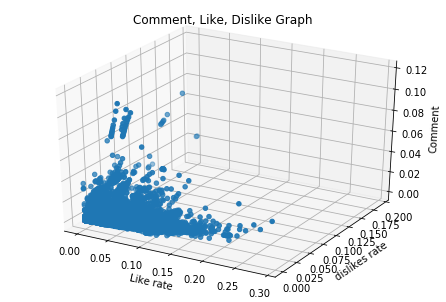

In [21]:
#Visualization
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(trending_vid_data_c['likes'],trending_vid_data_c['dislikes'],trending_vid_data_c['comment_count'])
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('Comment')
plt.title('Comment, Like, Dislike Graph')
plt.show()

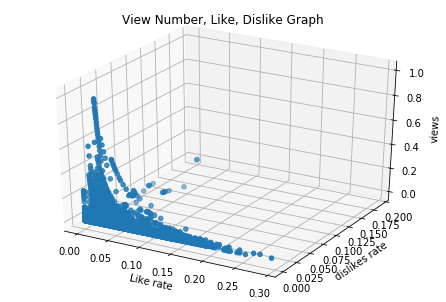

In [22]:
#Visualization2
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(trending_vid_data_c['likes'],trending_vid_data_c['dislikes'],trending_vid_data_c['views'])
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('views')
plt.title('View Number, Like, Dislike Graph')
plt.show()

From the second graph above, we can start to see some possible "clusters": there is one central cluster containing videos with relatively low views and moderate likes/dislikes; there is one that includes videos with super high view counts (the high part); there are some clusters capturing videos with high/low like/dislike rates. We can now proceed to the next step and start developing a clustering algorithm. 

## 3. Check the applicability of clustering through Hopkins Statistics Test
Before building our cluster model, it is worth examining if there is any clustering at all in the dataset. Hopkins Statistic evaluates whether a dataset has a significant non-random clustering structure. It will yield a value between 0 and 1, with 0.5 indicating a randomly distributed variable, 0-0.3 signals a regularly spaced dataset, while value more significant than 0.5 means a high tendency of clustering. (The implementation of this test is based on a shared previous application. It can be found here: https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/)

In [23]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(numpy.amin(X,axis=0),numpy.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H
hopkins(trending_vid_data_c)

0.9962948696615634

The result, 0.9962+, is very large, thus, performing clustering on this dataset is a reasonable choice.

## 4. Determine the optimal cluster number
Because we have no prior information on the number of clusters present here, an extra step is taken to help provide some information on the possible number of clusters. To accomplish that, we use the algorithm below to compare the sum of squared distance error for the different possible number of groups. It must be true that the more the cluster, the lower this variance will be, but too high a cluster number risks the chance of over-clustering and makes it harder to interpret the result.

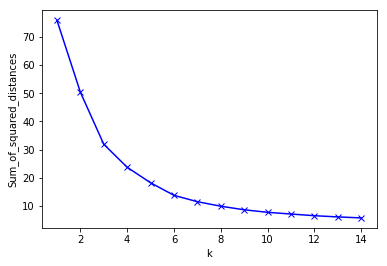

In [7]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(trending_vid_data_c)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

Here, as shown in this graph, a cluster number of around 5-6 is desirable for its low square error and relatively low chance of having a over-complicated model with too mant clusters.

## 5. Modelling and Cluster Visualization
Now, we have chosen the optimal cluster number being 5 and have finished all the preprocessing of data. It is the time to start training the model and visualizing the result.

In [26]:
cluster_num = 5
kmeans=KMeans(n_clusters=cluster_num,max_iter=3000)
kmeans.fit(trending_vid_data_c)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Below are the same graphs shown in the preprocessing section, with each color representing a different cluster.

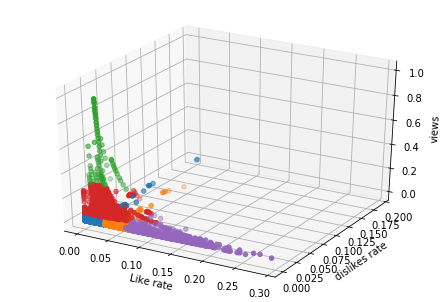

In [27]:
#visualization of result
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)

for i in range(cluster_num):
    ds = trending_vid_data_c.iloc[numpy.where(labels==i)]
    ax.scatter(ds['likes'],ds['dislikes'],ds['views'],'o')
   
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('views')
plt.show()

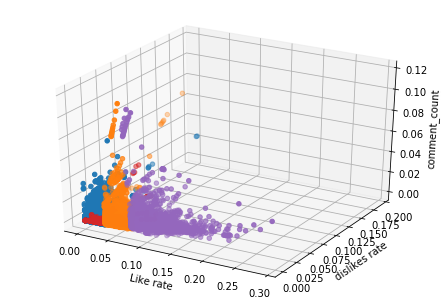

In [28]:
#visualization of result 2
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)

for i in range(cluster_num):
    ds = trending_vid_data_c.iloc[numpy.where(labels==i)]
    ax.scatter(ds['likes'],ds['dislikes'],ds['comment_count'],'o')
   
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('comment_count')
plt.show()

## 6. Model Accuracy and Significance
Since there is no "right" way of clustering videos, evaluating the significance of our clustering algorithm can be very hard indeed. After searching online, we found several alternative methods that can help estimate the effectiveness of clusters.
Note that we actually started the evaluation of model well before actually developing it. This includes the initial examination of the applicability of clustering and finding optimal cluster number through cross-validation.

### The Silhouette Coefficient
Lacking a given correct cluster, we must use the cluster model itself to evaluate its accuracy. The Silhouette Coefficient examines the effectiveness of clustering by comparing the mean distance between a sample and all points in the same cluster and between all points in the nearest cluster. It is already included in the sklearn package for use.

In [29]:
metrics.silhouette_score(trending_vid_data_c, labels, metric='euclidean')

0.4529938477205424

Here, a positive value indecates that the clustering are mostly correct. However, the value does not reach very close to 1, meaning the clustering, especially data points at the denser part, are not very clean (or seperated) from one another.


## 7. Interpretation of the result
Merely clusters tell no story about what the data looks like. To give meaning to the clusters identified by the model, we decided to look at the difference in characteristics among each cluster. 

In [30]:
#To Do: Split the original dataset according to clusters
trending_vid_data_cluster = []
for i in range(5):
    ds = trending_vid_data.iloc[numpy.where(labels==i)]
    trending_vid_data_cluster.append(ds)
#trending_vid_data_cluster[0]

### 7.1 Cluster Size
The first question is: do these clusters have similar size or is there a mega cluster accompanied by some smaller ones? 

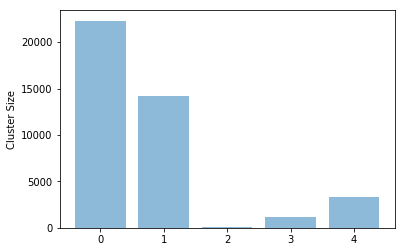

In [31]:
# Relative Size difference
size=[]
for i in trending_vid_data_cluster:
    size.append(len(i.index))
y_pos=numpy.arange(5)
plt.bar(y_pos, size, align='center', alpha=0.5)
plt.ylabel('Cluster Size')
 
plt.show()

As shown in the bar graph above, there are 2 clusters with significantly more videos while the other 2 are more "niche" and one has almost nothing. This result fits the common understanding of YouTube video since most trending videos must have shared something in a given culture, while other types of videos may get popular once in a while.

### 7.2 Categorical difference between Clusters 
A fundamental question that demands to be answered is whether this clustering model based on video statistics has any correlation with the category of videos. Do videos that share a similar view statistics tend to be from the same category or not? Is there any video category that tends to have extreme high/low like/ dislike rate? The following section aims to provide an answer to this question.

In [32]:
# Calculate the population distribution of each category in the original dataset
pop_distribution = []
pop_category = trending_vid_data['category_id']
for i in range(1,45):
    ds = trending_vid_data.iloc[numpy.where(pop_category==i)]
    pop_distribution.append(ds)
#pop_distribution[0]

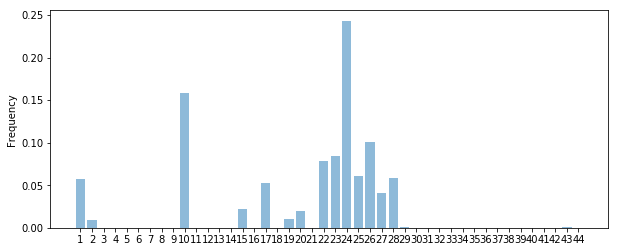

In [36]:
# Bar Graph showing population frequency
total_frequence = []
total = len(trending_vid_data.index)
for i in pop_distribution:
    total_frequence.append(len(i.index)/total)
y_pos=numpy.arange(1,45)

plt.figure(figsize=(10,4))
plt.bar(y_pos, total_frequence, align='center', alpha=0.5)
plt.xticks(numpy.arange(1,45))
plt.ylabel('Frequency')
 
plt.show()

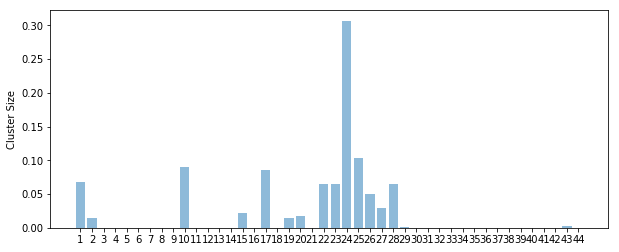

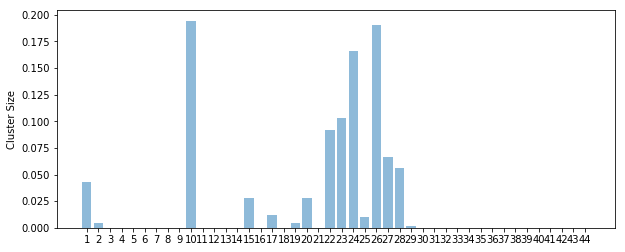

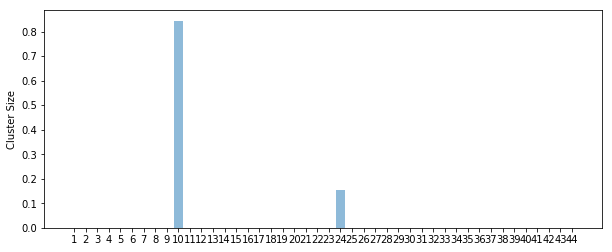

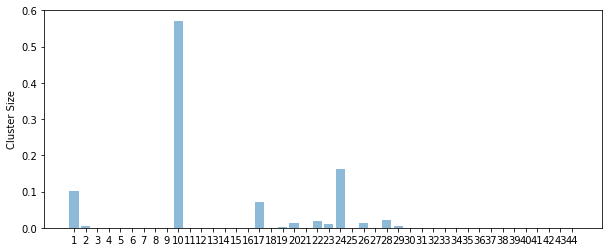

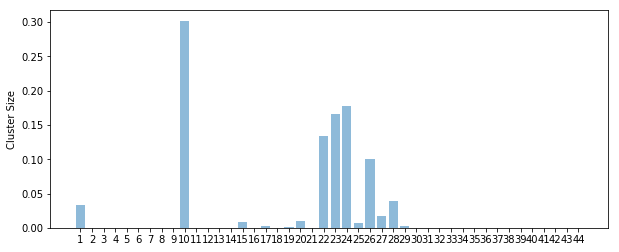

In [34]:
# Calculate the population distribution of each category in the original dataset
for num in range(5):
    cluster_distribution = []
    cluster_category = trending_vid_data_cluster[num]['category_id']
    for i in range(1,45):
        ds = trending_vid_data.iloc[numpy.where(cluster_category==i)]
        cluster_distribution.append(ds)
    #pop_distribution[0]
    # Bar Graph
    cluster_frequence = []
    cluster_size = len(trending_vid_data_cluster[num].index)
    for i in cluster_distribution:
        cluster_frequence.append(len(i.index)/cluster_size)
    y_pos=numpy.arange(1,45)
    plt.figure(figsize=(10,4))
    plt.bar(y_pos, cluster_frequence, align='center', alpha=0.5)
    plt.xticks(numpy.arange(1,45))
    plt.ylabel('Cluster Size')
 
    plt.show()


Here, each graph represents the distribution of a cluster. By comparing to the population distribution graph above, it is evident that each cluster contains different "kinds" of videos. For example, cluster 1, the biggest cluster, shares a similar overall distribution with the population except having far less video from category 10 and far more from category 24, while cluster 5 contains almost only videos from category 10. 
Now, we have shown that each cluster represents a different composition of video, it is our next step to show how this is connected to the view statistics difference between each cluster. At last, we can answer the question: is there any rule-of-thumb relationship between the category of video and its view statistics?

### 7.3 The Ultimate Question: How is video category related to view statistics?
To see how view statistics varies among clusters, we use the describe function on each cluster:

In [37]:
trending_vid_data_c_cluster = []
for i in range(5):
    ds = trending_vid_data_c.iloc[numpy.where(labels==i)]
    trending_vid_data_c_cluster.append(ds)

In [38]:
# Population Statistics
trending_vid_data_c.describe()

,views,likes,dislikes,comment_count
count,40949.000000,40949.000000,40949.000000,40949.000000
mean,0.010480,0.034413,0.001614,0.004453
std,0.032832,0.027009,0.003758,0.005736
min,0.000000,0.000000,0.000000,0.000000
25%,0.001074,0.014967,0.000556,0.001607
50%,0.003025,0.028273,0.000915,0.002961
75%,0.008093,0.046751,0.001601,0.005214
max,1.000000,0.290466,0.191531,0.117643


In [39]:
# Cluster 1 Statistics
trending_vid_data_c_cluster[0].describe()

,views,likes,dislikes,comment_count
count,22300.000000,22300.000000,22300.000000,22300.000000
mean,0.006571,0.016597,0.001718,0.002933
std,0.010057,0.008899,0.004310,0.003493
min,0.000000,0.000000,0.000000,0.000000
25%,0.000996,0.009007,0.000487,0.001102
50%,0.002921,0.016608,0.000867,0.001993
75%,0.007227,0.024335,0.001620,0.003447
max,0.064134,0.032944,0.191531,0.070348


In [40]:
# Cluster 2 Statistics
trending_vid_data_c_cluster[1].describe()

,views,likes,dislikes,comment_count
count,14165.000000,14165.000000,14165.000000,14165.000000
mean,0.006208,0.048022,0.001520,0.005407
std,0.009014,0.011024,0.003124,0.005834
min,0.000001,0.030427,0.000000,0.000000
25%,0.001104,0.038497,0.000636,0.002725
50%,0.002768,0.046206,0.000990,0.004076
75%,0.007374,0.055843,0.001621,0.006018
max,0.067994,0.074246,0.119827,0.117643


In [41]:
# Cluster 3 Statistics
trending_vid_data_c_cluster[2].describe()

,views,likes,dislikes,comment_count
count,77.000000,77.000000,77.000000,77.000000
mean,0.518098,0.027613,0.002202,0.003891
std,0.185861,0.012679,0.003113,0.003725
min,0.320614,0.009344,0.000333,0.000412
25%,0.377830,0.021581,0.001053,0.001399
50%,0.450182,0.025464,0.001525,0.002586
75%,0.612059,0.030320,0.001682,0.004031
max,1.000000,0.067027,0.014845,0.014761


In [42]:
# Cluster 4 Statistics
trending_vid_data_c_cluster[3].describe()

,views,likes,dislikes,comment_count
count,1113.000000,1113.000000,1113.000000,1113.000000
mean,0.119835,0.026179,0.001465,0.002588
std,0.059579,0.015239,0.003688,0.003996
min,0.063100,0.000000,0.000000,0.000000
25%,0.075702,0.016977,0.000555,0.001035
50%,0.093854,0.023243,0.000790,0.001759
75%,0.150903,0.033174,0.001393,0.002588
max,0.317747,0.114124,0.045567,0.045305


In [43]:
# Cluster 5 Statistics
trending_vid_data_c_cluster[4].describe()

,views,likes,dislikes,comment_count
count,3294.000000,3294.000000,3294.000000,3294.000000
mean,0.006502,0.099445,0.001356,0.011281
std,0.010428,0.027003,0.001691,0.010349
min,0.000013,0.064201,0.000090,0.000000
25%,0.000904,0.080861,0.000653,0.005903
50%,0.002703,0.090244,0.000959,0.008300
75%,0.007506,0.109599,0.001514,0.013481
max,0.095829,0.290466,0.021621,0.113489


As expected, each cluster has a lower variance on every feature. To best describe each cluster, the mean of each feature is compared to the population's mean, and we have the following result:
   
1:   -  ,   -    ,   +    ,    -
2:   -  ,   +   ,    -    ,   +
3:   +++  ,  -    ,   +    ,   -
4:  ++  ,   -      ,  -    ,   -
5:  -   ,  ++    ,   -   ,     -

each representing a feature's mean comparing against population mean, in the order of view, likes, dislikes, and comment. More than 1 symbol means it is much larger/smaller than the population mean.

Now, we can see that:
#### Cluster 1 
contains videos that has around the average view, with higher dislike rate and lower like rate.
#### Cluster 2 
contains videos that are around the average view count, with a higher like rate comment rate and fewer dislike.
#### Cluster 3 
contains only a handful of videos that are has super high view count, slightly high dislike rate and slightly low rate of like and comment.
#### Cluster 4 
includes videos that has pretty large view counts. Videos in this cluster has lower rate on anything else.
#### Cluster 5 
inlcudes videos with a much higher like rate, a slightly lower viewcount, and a slightly lower dislike and comment rate.

Now, adding to this characteristics the categorical difference discussed above we may see which kind of videos generally fits into which cluster. We found out that this clustering model has a typical "2 big+several small" distribution, meaning most videos has a close-to average view statistics, so the small clusters are particularly interesting. With the index provided by the dataset (the .json file), we have come to the following detailed conclusions: (There are many other possible conclusions, here are just some we find interesting)

#### 1. Only music and entertainment (#10 and #24) can become super super popular in terms of view count (AN era of mass entertainment, huh), but considering the fact these two categories are also the most commonly found video type, the success rate is pretty low (considering the size of "superhigh view" cluster is only below 100) 
#### 2. Even if you are only aiming at a higher-than-average view count (cluster 3 and 4), your best shot is still entertainment and music. Although there are videos from other categories existing in cluster 4(which means relatively big viewcount), the percetage is very low.
#### 3. Entertainment videos tend to have a higher like rate, since the only cluster with a low percentage of entertainment video is the largest cluster with low like rate, this kind of video also are most likely to receive most likes since it contributes greatly to cluster 5. This is reasonable since it has a larger audience.
#### 4. The "Howto & Style" videos (#26) almost only exists in cluster 2 and 5, which means that this kind of video typically has a smaller view counts due to its specialized audience, but on average they has a good reputation and people would want to give likes and comments (which is exactly what I oberse on YouTube)
#### 5. The "News & Politics" Videos (#25) are never too popular. It is almost always found in cluster 1, which means typically news videos have around average view counts in the trending videos, and due to its nature of causing conflict of opinions, it is not so hard to understand it typically has high dislike rate. (Think about Fox and CNN, the war of "fake news")

## 8. Further development and other questions that need to be answered
Here, we have finished the development of this model, but there are many other things this model can do. We have only analyzed data from one country, what about others? Do people from different countries love similiar kind of video, or are they drastically different? In this final section, we will briefly touch on subjects like this.

### 8.1 The difference between nations
We may run the exact same model on dataset from other countries, and compare it with the model above. The following is the model run on russian data.

In [45]:
trending_vid_data = pandas.read_csv('FRvideos.csv')

trending_vid_data.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...
1,Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...
2,ceqntSXE-10,17.14.11,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...
3,WuTFI5qftCE,17.14.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o..."
4,ee6OFs8TdEg,17.14.11,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13T16:30:03.000Z,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...


In [46]:
#Eliminate unnecessary columns
trending_vid_data_c = trending_vid_data.drop(axis=1 ,columns=['publish_time','video_id','trending_date','title','channel_title','category_id','tags','thumbnail_link','comments_disabled','ratings_disabled','video_error_or_removed','description'])
size =len(trending_vid_data_c.index)
trending_vid_data_c=trending_vid_data_c.astype('float64')
#Process into rates
for i in range(size):
    ratio1=trending_vid_data_c['likes'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['likes'][i]=ratio1
    
    ratio2=trending_vid_data_c['dislikes'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['dislikes'][i]=ratio2
    
    ratio3=trending_vid_data_c['comment_count'][i]/trending_vid_data_c['views'][i]
    trending_vid_data_c['comment_count'][i]=ratio3
    
#Normalize view number
trending_vid_data_c['views']=(trending_vid_data_c['views']-trending_vid_data_c['views'].min())/(trending_vid_data_c['views'].max()-trending_vid_data_c['views'].min())
trending_vid_data_c.head()

,views,likes,dislikes,comment_count
0,0.002106,0.137667,0.005209,0.017945
1,0.004286,0.032476,0.001331,0.002683
2,0.004776,0.158047,0.000989,0.019869
3,0.009166,0.091887,0.000594,0.004651
4,0.001402,0.057102,0.000508,0.003395


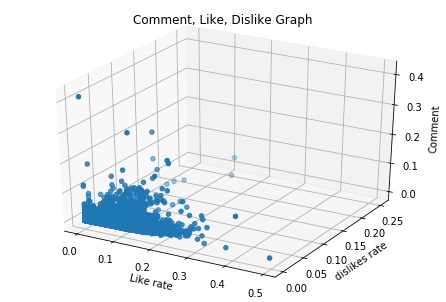

In [47]:
#Visualization
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(trending_vid_data_c['likes'],trending_vid_data_c['dislikes'],trending_vid_data_c['comment_count'])
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('Comment')
plt.title('Comment, Like, Dislike Graph')
plt.show()

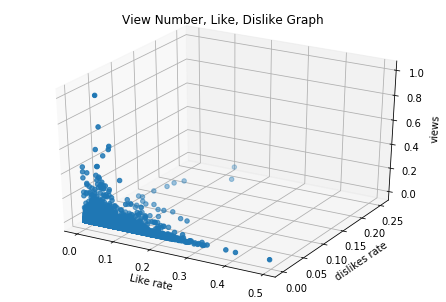

In [48]:
#Visualization2
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(trending_vid_data_c['likes'],trending_vid_data_c['dislikes'],trending_vid_data_c['views'])
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('views')
plt.title('View Number, Like, Dislike Graph')
plt.show()

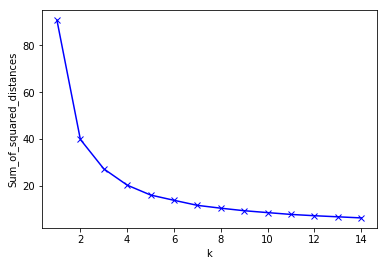

In [49]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(trending_vid_data_c)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

In [50]:
cluster_num = 5
kmeans=KMeans(n_clusters=cluster_num,max_iter=3000)
kmeans.fit(trending_vid_data_c)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=3000,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

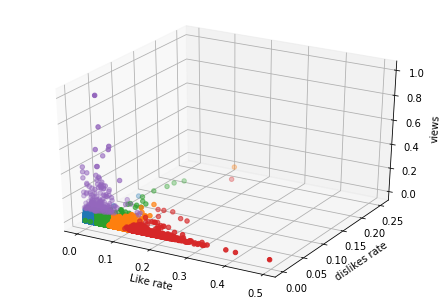

In [51]:
#visualization of result
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)

for i in range(cluster_num):
    ds = trending_vid_data_c.iloc[numpy.where(labels==i)]
    ax.scatter(ds['likes'],ds['dislikes'],ds['views'],'o')
   
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('views')
plt.show()

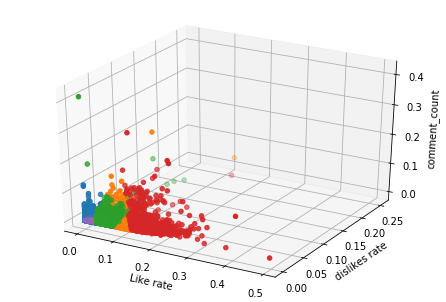

In [52]:
#visualization of result 2
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
fig = plt.figure()
ax = Axes3D(fig)

for i in range(cluster_num):
    ds = trending_vid_data_c.iloc[numpy.where(labels==i)]
    ax.scatter(ds['likes'],ds['dislikes'],ds['comment_count'],'o')
   
ax.set_xlabel('Like rate')
ax.set_ylabel('dislikes rate')
ax.set_zlabel('comment_count')
plt.show()

In [53]:
#To Do: Split the original dataset according to clusters
trending_vid_data_cluster = []
for i in range(5):
    ds = trending_vid_data.iloc[numpy.where(labels==i)]
    trending_vid_data_cluster.append(ds)
#trending_vid_data_cluster[0]

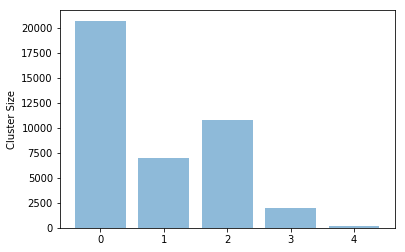

In [54]:
# Relative Size difference
size=[]
for i in trending_vid_data_cluster:
    size.append(len(i.index))
y_pos=numpy.arange(5)
plt.bar(y_pos, size, align='center', alpha=0.5)
plt.ylabel('Cluster Size')
 
plt.show()

In [55]:
# Calculate the population distribution of each category in the original dataset
pop_distribution = []
pop_category = trending_vid_data['category_id']
for i in range(1,45):
    ds = trending_vid_data.iloc[numpy.where(pop_category==i)]
    pop_distribution.append(ds)
#pop_distribution[0]

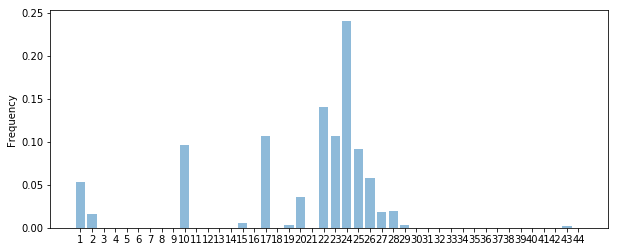

In [56]:
# Bar Graph showing population frequency
total_frequence = []
total = len(trending_vid_data.index)
for i in pop_distribution:
    total_frequence.append(len(i.index)/total)
y_pos=numpy.arange(1,45)

plt.figure(figsize=(10,4))
plt.bar(y_pos, total_frequence, align='center', alpha=0.5)
plt.xticks(numpy.arange(1,45))
plt.ylabel('Frequency')
 
plt.show()

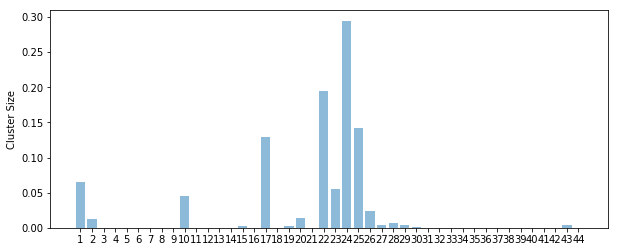

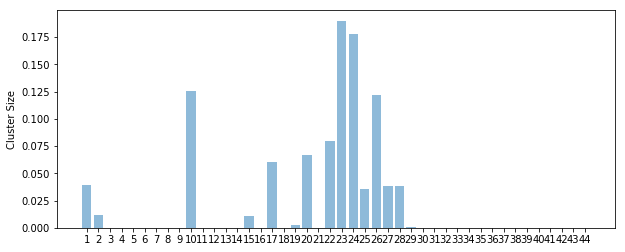

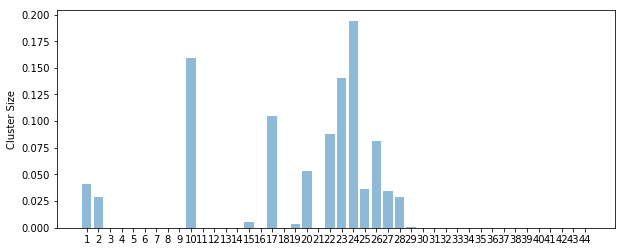

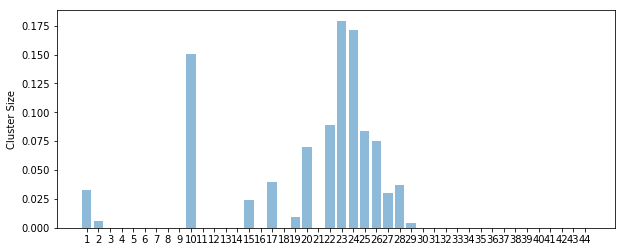

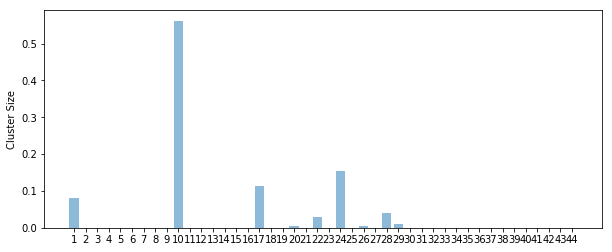

In [57]:
# Calculate the population distribution of each category in the original dataset
for num in range(5):
    cluster_distribution = []
    cluster_category = trending_vid_data_cluster[num]['category_id']
    for i in range(1,45):
        ds = trending_vid_data.iloc[numpy.where(cluster_category==i)]
        cluster_distribution.append(ds)
    #pop_distribution[0]
    # Bar Graph
    cluster_frequence = []
    cluster_size = len(trending_vid_data_cluster[num].index)
    for i in cluster_distribution:
        cluster_frequence.append(len(i.index)/cluster_size)
    y_pos=numpy.arange(1,45)
    plt.figure(figsize=(10,4))
    plt.bar(y_pos, cluster_frequence, align='center', alpha=0.5)
    plt.xticks(numpy.arange(1,45))
    plt.ylabel('Cluster Size')
 
    plt.show()

This is still an incomplete analysis, but till now, we have descovered various difference between the US dataset and the French dataset. First, French has 1 mega clusters instead of 2, has 3 middle sized cluster instead of 2, and one small cluster like the US one; Second, French videos do not have a differnence of categorical distribution as obvious as the US, the large and medium clusters all resembles the population distribution more than its US counterparts. Of course, this is not a definitive answer to the question of whether there are obvious difference in viewer behavior, but it shows strong support on the idea that each countries has a very culture-specific composition of trending videos.

# Model 2: Does Popularity Causes Popularity?
# A Prediction Modelling Approach to the time-dependency on Video Popularity

## 1. Introduction

In the previous model, we have examines how different category of videos have various viewer statistics. It is a static model that does not take into account the change through time, so what about time? Does a video with high initial view tend to attract more viewers and be more successful, or does the increased view count has little dependence on previous view count? Is there an effect similar to "The Big gets Bigger" on Youtube? If there is such a relationship, will they be linear, or will they have some more exciting and intricate characteristics? 

Since we want to predict which video is going to be popular by looking at their initial performance, we first try to visualize the effect of time on a single video; if time causes a linear increase on every statistics of a video, this may suggest that the initial and final statistics for every video also have a linear relation (if the slope for the increase is similiar among videos). After examining the trend on a single video, we will develop the main model with the purpose of predicting the increase of popularity for any given video based on its initial popularity, or its statistics like likes, dislikes, viewcounts, etc. in particular.

The dataset we are using is the following:Youtube Videos ViewCount every hour (Link: https://www.kaggle.com/nnqkfdjq/statistics-observation-of-random-youtube-video#count_observation_upload.csv)

In [1]:
# import necessary packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import random
import numpy as np

## 2. Data Cleaning and Preparation
In this step, we get rid of some ofthe unnecessary columns in the original dataset and also split out the first sub-dataset used in the process of determining the role of time on a given video's view statistics.

In [2]:
data = pd.read_csv('count_observation_upload.csv')
df=data.drop(['commentCount_diff','dislikeCount_diff','favoriteCount_diff','likeCount_diff',
              'viewCount_diff','favoriteCount'],axis=1)
#drop favorite count since this data lacks these info(all 0 in the dataset)
#drop other columns since we do not need these info for building our models.
df1=df.loc[df['videoId']=="FzG4uDgje3M"] # Seperate out the data for a specific video through time
df1=df1.dropna()#drop the NaN entries
df1.head()

,Unnamed: 0,index,videoId,commentCount,dislikeCount,likeCount,viewCount,Time
0,0,0,FzG4uDgje3M,131330.0,411967.0,1993172.0,281321552.0,2018-05-07 18:00:00
1,1,1,FzG4uDgje3M,131410.0,412203.0,1994314.0,281468577.0,2018-05-07 19:00:00
2,2,2,FzG4uDgje3M,131562.0,412511.0,1995697.0,281915631.0,2018-05-07 20:00:00
3,3,3,FzG4uDgje3M,131690.0,412836.0,1997352.0,282044028.0,2018-05-07 21:00:00
4,4,4,FzG4uDgje3M,131857.0,413237.0,1999256.0,282380859.0,2018-05-07 22:00:00


Now, to give some insight on what the viewcount change is like for a single video, several graphs are made:

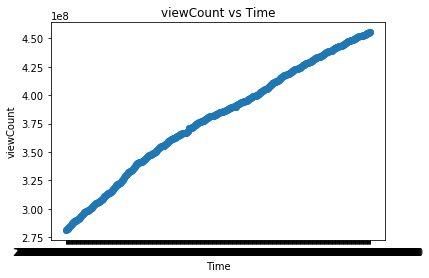

In [3]:
plt.scatter(df1['Time'],df1['viewCount'])
plt.title('viewCount vs Time')
plt.xlabel('Time')
plt.ylabel('viewCount')
plt.show()#we can see the viewcount and time forms a linear relationship.

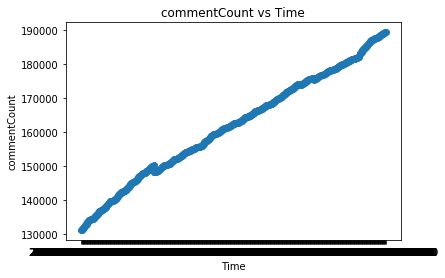

In [4]:
plt.scatter(df1['Time'],df1['commentCount'])
plt.title('commentCount vs Time')
plt.xlabel('Time')
plt.ylabel('commentCount')
plt.show()

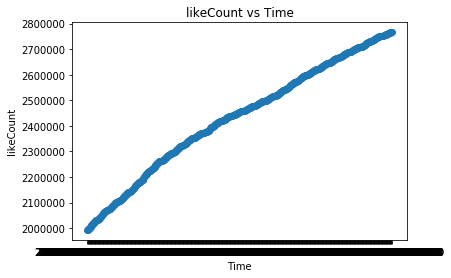

In [5]:
plt.scatter(df1['Time'],df1['likeCount'])
plt.title('likeCount vs Time')
plt.xlabel('Time')
plt.ylabel('likeCount')
plt.show()

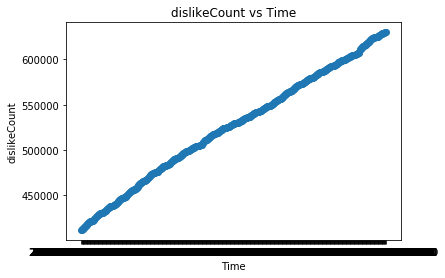

In [6]:
plt.scatter(df1['Time'],df1['dislikeCount'])
plt.title('dislikeCount vs Time')
plt.xlabel('Time')
plt.ylabel('dislikeCount')
plt.show()

## 3. Modelling the effect of time on a single video
Judging by the shape of the curve above, we conclude that all statistics have a linear relationship against time. To test our hypothesis, one linear regression model is made for each relationship with standard train-test split and cross-validation.


We train a linearRegression model to model the linear relation between viewCount and Time. Also, since the time in the dataset are strings and cannot be used to train our model, we could let the initial record time be 0, and since we have data recorded every hour, the index column can be traeted as the "time" variable.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df1[['viewCount']], df1[['index']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9879031316328957

We get a pretty high score, which indecates our linear model of viewcount and time is pretty accurate. Thus, we could have the conclusion that if the initial viewcount is high, the final viewcount will also be high. We do the similar process for the rest counts and try to find teh relation between these counts and time.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df1[['commentCount']], df1[['index']],
                                                    test_size=0.2, random_state=42)
#we could let the first record time be 0, and since we have data recorded every hr, 
#the index of the rows could represent teh time elapsed since the start of record.
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9957487072681469

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df1[['likeCount']], df1[['index']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9870919411503317

In [10]:
x_train, x_test, y_train, y_test = train_test_split(df1[['dislikeCount']], df1[['index']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9971574888627115

These count and time all have linear relation, and these linear relations indicate that the initial commentcount, viewcount, likecount, dislikecount, and their corresponding final values also have linear relations. Initially we thought that linear models can be used to predict the possible final data from the initial statistics, but we soon found out that this model would not yield a descriptive result.

## 4. Main Model: Modelling the relationship between video's growth over a given time period and its initial performance

Initially, we decided to predict the final statistics from the initial statistics, but we noticed a possible cause for unacceptable error in this kind of model: the direct effect of initial counts on final counts. Since the initial counts for most videos are very big compare to the increase in this time peroid, <strong><em>the initial values could have too big an influence on the final values</strong></em> and therefore <strong><em>could significantly affect the modelling of relation and the accesment of accuracy  for the model</strong></em>. (In fact we have done some models this way, and every linear model shows a really low slope and really high score (>0.99) since the difference in increase is just too small compare to the huge initial value)To address this, we plot graphs and construct models of the initial counts and the <strong><em>difference</strong></em> between the final counts and the initial counts. i.e., we plot graphs and build models of the initial counts and the value of (final_count - initial_count) to elimiate the "fakely accurate" models that could be caused by the big initial value.

### 4.1 Further data preparation and visualization

We can see that we do have some null values in df3 and we need to fill them with mean value. 
We could choose mean because the dataset is relatively big, thus teh mean value could be a good representation of the possible NaN values. Then we change the value of counts in df3 to the difference betweeen the final counts and the initial counts to eliminate the influence of the initial values on the accuracy.

In [11]:
df2=df.loc[df['Time']=='2018-05-07 18:00:00']  #Initial Performance
df3=df.loc[df['Time']=='2018-06-05 16:00:00']  #Final Performance
print(pd.isnull(df2).sum() > 0)
print(pd.isnull(df3).sum() > 0)

df3['commentCount']=df3['commentCount'].fillna(df3['commentCount'].mean())
df3['dislikeCount']=df3['dislikeCount'].fillna(df3['dislikeCount'].mean())
df3['likeCount']=df3['likeCount'].fillna(df3['likeCount'].mean())
df3['viewCount']=df3['viewCount'].fillna(df3['viewCount'].mean())

#difference between initial count and final count
df3['commentCount']=df3['commentCount'].values-df2['commentCount'].values
df3['dislikeCount']=df3['dislikeCount'].values-df2['dislikeCount'].values
df3['likeCount']=df3['likeCount'].values-df2['likeCount'].values
df3['viewCount']=df3['viewCount'].values-df2['viewCount'].values
print(pd.isnull(df3).sum() > 0) #filled all teh NaN values successfully.

Unnamed: 0      False
index           False
videoId         False
commentCount    False
dislikeCount    False
likeCount       False
viewCount       False
Time            False
dtype: bool
Unnamed: 0      False
index           False
videoId         False
commentCount     True
dislikeCount     True
likeCount        True
viewCount        True
Time            False
dtype: bool


C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

Unnamed: 0      False
index           False
videoId         False
commentCount    False
dislikeCount    False
likeCount       False
viewCount       False
Time            False
dtype: bool


C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\19665\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [12]:
df2.head()

,Unnamed: 0,index,videoId,commentCount,dislikeCount,likeCount,viewCount,Time
0,0,0,FzG4uDgje3M,131330.0,411967.0,1993172.0,281321552.0,2018-05-07 18:00:00
695,695,0,LOYAomlRbxI,13009.0,33188.0,706006.0,80762575.0,2018-05-07 18:00:00
1390,1390,0,Bm8rz-llMhE,14108.0,22212.0,647831.0,56259050.0,2018-05-07 18:00:00
2085,2085,0,pd7AMDMotyM,31895.0,41267.0,688754.0,53295716.0,2018-05-07 18:00:00
2780,2780,0,4kDklB6-69Q,69616.0,20403.0,1048729.0,46531812.0,2018-05-07 18:00:00


In [13]:
df3.head()

,Unnamed: 0,index,videoId,commentCount,dislikeCount,likeCount,viewCount,Time
694,694,694,FzG4uDgje3M,57945.0,217845.0,773068.0,174162471.0,2018-06-05 16:00:00
1389,1389,694,LOYAomlRbxI,5347.0,11916.0,165504.0,46932826.0,2018-06-05 16:00:00
2084,2084,694,Bm8rz-llMhE,1184.0,4892.0,101808.0,16873368.0,2018-06-05 16:00:00
2779,2779,694,pd7AMDMotyM,1914.0,4709.0,71034.0,16417437.0,2018-06-05 16:00:00
3474,3474,694,4kDklB6-69Q,10867.0,7536.0,252170.0,27965915.0,2018-06-05 16:00:00


Now, we try to find the relationship between the initial performance and final performance of videos.
We expect this to be a linear relationship according to our pervious analysis, which means that videos on YouTube obey the "Big gets Bigger" effect. We first need to 
visualize their relationship to confirm our prediction.
Since these data for the ith entries in df2 and df3 are of the same video, we do not need to alter teh 
position of rows of df2 and df3 since they are alerady matched.

#### 4.1.1 Comment vs Comment increase

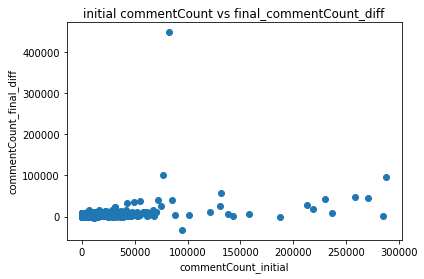

In [14]:
plt.scatter(df2['commentCount'],df3['commentCount'])
plt.title('initial commentCount vs final_commentCount_diff')
plt.xlabel('commentCount_initial')
plt.ylabel('commentCount_final_diff')
plt.show()

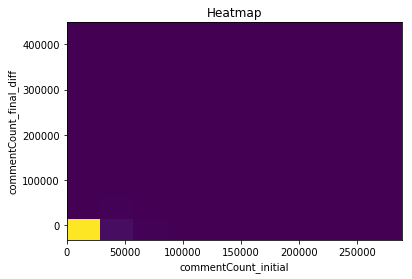

In [15]:
Z, hmx, hmy = np.histogram2d(df2['commentCount'],df3['commentCount'])

plt.title('Heatmap')
plt.xlabel('commentCount_initial')
plt.ylabel('commentCount_final_diff')
plt.pcolormesh(hmx,hmy,Z.T)

plt.show()

From the graph above, we conclude that our prediction of a linear relationship for commentCount is <strong><em>not</strong></em> correct and this error could be caused by the big initial value of the commentCount. We could see that the initial comment count does not quite influence the final commentCount since from the plots we can see that the commentCount difference is nearly the same for all initial comment values, and the density is also nearly the same for all different values. According to the scatter plot, we could try to use both linearRegression model and ploy model to predict their relation, but we may <strong><em>not</strong></em> get a high score since these two counts are not actually tightly correlated.

#### 4.1.2 Dislike vs Dislike increase

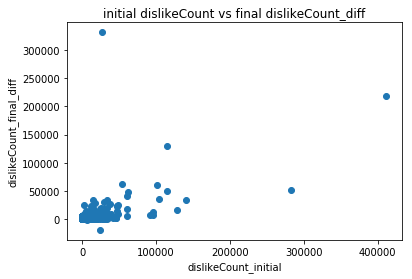

In [16]:
plt.scatter(df2['dislikeCount'],df3['dislikeCount'])
plt.title('initial dislikeCount vs final dislikeCount_diff')
plt.xlabel('dislikeCount_initial')
plt.ylabel('dislikeCount_final_diff')
plt.show()

From the graph above, we can see that our assumption of a linear relationship is somewhat accurate, as those who has high initial dislikes gets more dislikes.

#### 4.1.3 Like vs Like increase

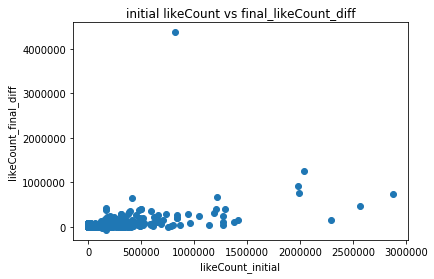

In [17]:
plt.scatter(df2['likeCount'],df3['likeCount'])
plt.title('initial likeCount vs final_likeCount_diff')
plt.xlabel('likeCount_initial')
plt.ylabel('likeCount_final_diff')
plt.show()

From the graph above, we can see that our assumption of a linear relationship is somewhat accurate, as those who has high initial likes gets more likes.

### 4.2 Building a Model for each relationship

#### 4.2.1(a) LinearRegression model: initial commentCount and commentCount increase

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df2[['commentCount']], df3[['commentCount']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.19337335880250875

#### 4.2.1(b) poly model: initial commentCount and commentCount increase

In [19]:
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(x_train, y_train)
poly_model.score(x_test, y_test)

0.2013606105215069

Here, both model failed to provide a satisfactory result. As mentioned in the visualization part, we believe this result verifies our idea that comment increase is somewhat not dependent on the initial comments.

#### 4.2.2 (a) LinearRegression model: initial dislikeCount and dislikeCount increase¶

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df2[['dislikeCount']], df3[['dislikeCount']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.5099655509613146

#### 4.2.2 (b) poly model: initial dislikeCount and dislikeCount increase

In [21]:
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(x_train, y_train)
poly_model.score(x_test, y_test)

0.39714707566088814

The higher modelling score for linear model verifies our idea that the initial dislikeCount and dislikeCount_diff between the initial dislikeCount and final dislikeCouunt is more a linear relation; in other words, if there are more people dislike a video at the beginning when the video is posted, then more likely there are more people dislike this video after time.

#### 4.2.3 (a) LinearRegression model: initial likeCount and likeCount increase

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df2[['likeCount']], df3[['likeCount']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.5198182179104062

#### 4.2.3(b) poly model: initial likeCount and likeCount increase¶

In [23]:
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(x_train, y_train)
poly_model.score(x_test, y_test)

0.44440051723076035

We could see from the previous plot and analysis that the initial likeCount and likeCount_diff between the initial likeCount and final likeCouunt is more a linear relation; in other words, if there are more people like a video at the beginning when the video is posted, then more likely there are more people like this video after time. This ralation is similar to those found on the initial dislike and final_dislike_diff relation, which is reasonable.

#### 4.2.4(a) LinearRegression model: initial viewCount and viewCount increase

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df2[['viewCount']], df3[['viewCount']],
                                                    test_size=0.2, random_state=42)
model = LinearRegression()
model = model.fit(x_train, y_train)
model.score(x_test, y_test)

0.764144432898527

#### 4.2.4(b) poly model: initial viewCount and viewCount increase

In [25]:
poly_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_model.fit(x_train, y_train)
poly_model.score(x_test, y_test)

0.8844861772127124

From the plot and analysis above, we could see that the initial viewCount and the difference between the initial viewCount and final viewCount is more a ploynomial relation; this means that if there are more people view the video at the beginning when the video is posted, there are more likely to be much more people to view the video after time. It seems very reasonable for this to be a non-linear relationship since one people views the video usually means this video will be more popular, and viewers are more likely to click and watch an already-popular video. This kind of exponencial growth is a key characteristics of the "Big gets Bigger" effect, and it can be found in other places like competition between firms.

## 5. Interpretation of the result

Our result shows that the initial performance of a video is not necessary linearly correlated to its final performance. <br><br>
From the analysis above, we could see that the initial comment count does not influence the change of comment count after time and these two values are not tightly correlated. Therefore we could not say a video will get more comments because it gets many comments initially. <br><br>
For the like and dislike counts, these initial values seem to have a more linear relationship with the change of like/dislike counts overtime, which means that we could predict if a video has more like-count at the beginning, it is more likely to have proportionally more like/dislike after time.<br><br>
For the viewCounts, these initial values seem to have a more polynomial relation with the change of viewCounts overtime. Therefore, we could predict that if a video has more viewCounts initially, it is more likely to have a lot more viewCounts after time. In other words, if YouTubers wants to make their videos popular after time, it is better for them to try to attract as many people as they can to view their video at the very beginning when the video is released since this will significantly improve the final viewCounts.<br><br>
By implementing this model on real-life data, we could predict the final performance of YouTube videos by looking at their first performance. The insight this model provides is beneficial for YouTubers since they can gain prior information on whether or not their video will become viral and what to do to increase this chance by setting early-stage targets on certain kind of counts(views, likes, etc.). For example, our model can help predict the result for different advertising strategies (mass stream or specialized advertisement?) with different initial statistics boost(mass stream dramatically increase your view count, but may hurt you by adding dislikes) for YouTubers so that they can find the optimal strategy.